In [1]:
import pandas as pd
dataset = pd.read_csv('/kaggle/input/yelp-reviews-dataset/yelp.csv', encoding='utf-8')

In [2]:
print(dataset.isnull().sum())

business_id    0
date           0
review_id      0
stars          0
text           0
type           0
user_id        0
cool           0
useful         0
funny          0
dtype: int64


# Preprocessing text

In [5]:
import nltk
!pip install contractions
import contractions
import string
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 8.0 MB/s eta 0:00:00
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
# lower case
# punctuation remove (bỏ dấu câu)
# contraction expansion (xử lí từ viết tắt you're -> you are)
# tokenization
# RegexTokenizer
# stopword remove
# stemming hoặc lemma (lemma tốt hơn)
# loại bỏ số và ký tự đặc biệt
import re
def manual_lemmatize(word):
    irregulars = {
        'children': 'child',
        'mice': 'mouse',
        'geese': 'goose',
        'feet': 'foot',
        'teeth': 'tooth',
        'men': 'man',
        'women': 'woman',
        'better': 'good',
        'best': 'good',
        'worse': 'bad',
        'worst': 'bad',
    }

    # Check for irregular forms
    if word in irregulars:
        return irregulars[word]

    # Handle plurals
    if re.search(r'ies$', word):
        return re.sub(r'ies$', 'y', word)
    elif re.search(r'es$', word):
        return re.sub(r'es$', '', word)
    elif re.search(r's$', word) and not re.search(r'ss$', word):
        return re.sub(r's$', '', word)

    # Handle verbs ending in 'ing' (simplified)
    if re.search(r'ing$', word):
        return re.sub(r'ing$', 'e', word) if re.search(r'[aeiou][^aeiou]ing$', word) else re.sub(r'ing$', '', word)

    # Handle verbs ending in 'ed' (simplified)
    if re.search(r'ed$', word):
        return re.sub(r'ed$', '', word)
    return word


In [7]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english')) - {"not", "no", "never", "n't"}

def preprocess(text):
    text = re.sub(r'<br\s*/?>', ' ', text)
    # Chuyển thành chữ thường
    text = text.lower()

    # Xử lý từ viết tắt
    text = contractions.fix(text)  # "you're" -> "you are", "isn't" -> "is not"

    # Loại bỏ dấu câu
    text = re.sub(r'[^\w\s]', ' ', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Loại bỏ stopwords nhưng giữ từ phủ định
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    tokens = [manual_lemmatize(word) for word in tokens]

    return " ".join(tokens)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
feature = [preprocess(text) for text in dataset['text']]

In [9]:
max_sentence = 0
unique_words = set()
for sentence in feature:
  b =str(sentence).split()
  a = len(b)
  unique_words.update(b)
  max_sentence = max(a, max_sentence)
vocab_size = len(unique_words)
print(max_sentence) # 528
print(vocab_size) # 23484

528
23484


In [10]:
from collections import Counter


word_counter = Counter()
for sentence in feature:
    words = str(sentence).split()
    word_counter.update(words)


threshold = 3
filtered_vocab = {word for word, count in word_counter.items() if count >= threshold}

# Cập nhật vocab size sau khi lọc
vocab_size = len(filtered_vocab)
print("New vocab size:", vocab_size)

New vocab size: 10660


In [11]:
filtered_feature = []
for sentence in feature:
    words = [word if word in filtered_vocab else "<UNK>" for word in str(sentence).split()]
    filtered_feature.append(" ".join(words))

In [12]:
max_sentence = 0
unique_words = set()
for sentence in filtered_feature:
  b =str(sentence).split()
  a = len(b)
  unique_words.update(b)
  max_sentence = max(a, max_sentence)
vocab_size = len(unique_words)
print(max_sentence) # 528
print(vocab_size) # 10661

528
10661


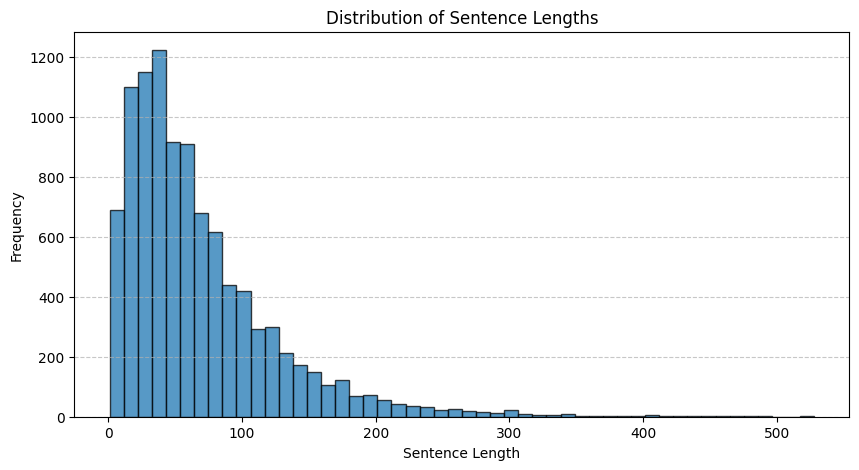

In [13]:
import matplotlib.pyplot as plt
sentence_lengths = [len(str(sentence).split()) for sentence in filtered_feature]


plt.figure(figsize=(10, 5))
plt.hist(sentence_lengths, bins=50, alpha=0.75, edgecolor='black')
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.title("Distribution of Sentence Lengths")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [14]:
import numpy as np


max_length = 156

valid_sentences = np.sum(np.array(sentence_lengths) <= max_length)
total_sentences = len(sentence_lengths)

coverage = (valid_sentences / total_sentences) * 100
print(f"Chọn max_length = {max_length} sẽ giữ lại {coverage:.2f}% dữ liệu.")

Chọn max_length = 156 sẽ giữ lại 92.31% dữ liệu.


In [15]:
dataset['cleaned'] = filtered_feature


In [16]:
dataset['text length'] = dataset['cleaned'].apply(len)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

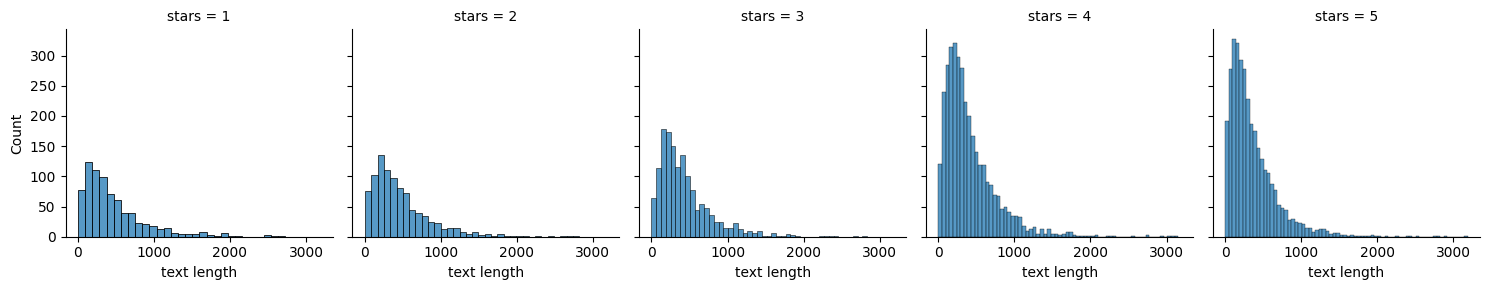

In [17]:
import seaborn as sns
sns.FacetGrid(data=dataset,col='stars').map(sns.histplot,'text length')

In [18]:
new_dataset = dataset[dataset['text length'] <= 1500]


In [19]:
def map_star_class(star):
    if star in [1, 2]:  
        return 0
    elif star == 3: 
        return 1
    else:  
        return 2

# Áp dụng hàm trên cột "star"
new_dataset["stars"] = new_dataset["stars"].apply(map_star_class)

<ipython-input-19-0b730d92867d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_dataset["stars"] = new_dataset["stars"].apply(map_star_class)


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

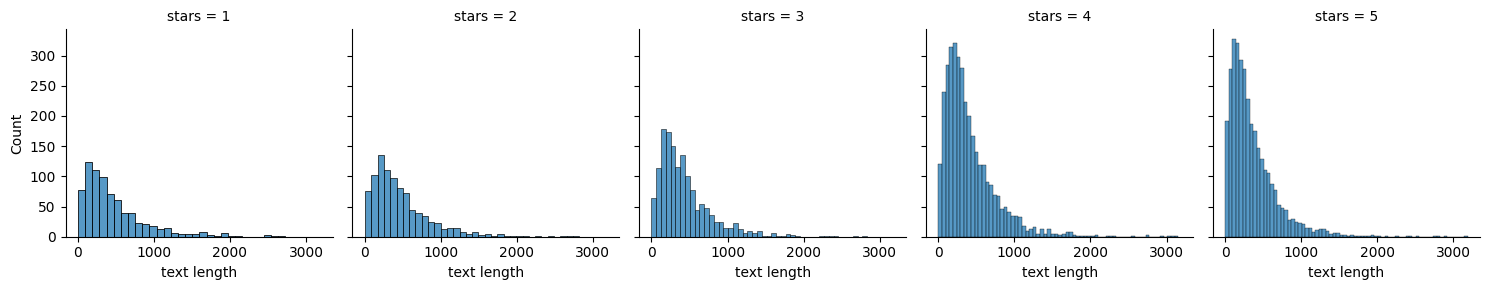

In [20]:
sns.FacetGrid(data=dataset,col='stars').map(sns.histplot,'text length')

In [ ]:
X = new_dataset["cleaned"]
y = new_dataset["stars"]

In [23]:
from sklearn.utils import resample


X_upsampled1, y_upsampled1 = resample(X[y == 0],
                                    y[y == 0],
                                    replace=True,
                                    n_samples=X[y == 2].shape[0],
                                    random_state=123)

X_upsampled2, y_upsampled2 = resample(X[y == 1],
                                     y[y == 1],
                                     replace=True,
                                     n_samples=X[y == 2].shape[0],
                                     random_state=123)


print('Number of class 1 examples after:', X_upsampled1.shape[0])
print('Number of class 2 examples after:', X_upsampled2.shape[0])

Number of class 1 examples after: 6770
Number of class 2 examples after: 6770


In [24]:
X_bal = np.hstack((X[y == 2], X_upsampled1, X_upsampled2))
y_bal = np.hstack((y[y == 2], y_upsampled1, y_upsampled2))
X_bal.shape, y_bal.shape

((20310,), (20310,))

In [25]:
import torch
import torch.nn as nn
from transformers import DistilBertTokenizer
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import TensorDataset, DataLoader


from transformers import RobertaTokenizer


tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
X = X_bal.tolist()
y = y_bal.tolist()

x_train, x_test, y_train, y_test = train_test_split(
    X,  # Raw text list
    y,  # Labels
    test_size=0.2, 
    random_state=42,
    stratify = y
)

train_encodings = tokenizer(x_train, padding="max_length", truncation=True, max_length=156, return_tensors="pt")
test_encodings = tokenizer(x_test, padding="max_length", truncation=True, max_length=156, return_tensors="pt")

y_train_tensor = torch.tensor(np.array(y_train).astype(np.float32))
y_test_tensor = torch.tensor(np.array(y_test).astype(np.float32))

train_dataset = TensorDataset(train_encodings["input_ids"], train_encodings["attention_mask"], y_train_tensor)
val_dataset = TensorDataset(test_encodings["input_ids"], test_encodings["attention_mask"], y_test_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

print("Train Input Shape:", train_encodings["input_ids"].shape)  # (num_samples, max_length)
print("Train Label Shape:", y_train_tensor.shape)  # (num_samples,)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Train Input Shape: torch.Size([16248, 156])
Train Label Shape: torch.Size([16248])


In [26]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5) 
from transformers import RobertaForSequenceClassification

model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=3)
model.to(device)

model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

device

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


device(type='cuda')

In [27]:
import torch
import torch.nn as nn
from tqdm import tqdm

num_epochs = 10

for epoch in range(num_epochs):  
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    # tqdm để hiển thị progress bar
    loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

    for batch in loop:
        inputs, masks, labels = batch
        inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)

        # Đảm bảo labels có đúng kiểu dữ liệu
        labels = labels.to(torch.long)

        optimizer.zero_grad()
        outputs = model(input_ids=inputs, attention_mask=masks).logits  # Không cần squeeze()

        loss = criterion(outputs, labels)  # CrossEntropyLoss tự động xử lý softmax
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        # Sử dụng logits trực tiếp mà không cần softmax()
        preds = torch.argmax(outputs, dim=1)  
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

        # Cập nhật progress bar
        loop.set_postfix(loss=loss.item(), acc=correct_train/total_train)

    train_loss = total_train_loss / len(train_dataloader)
    train_acc = correct_train / total_train

    # ================== Validation ===================
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch in val_dataloader:
            inputs, masks, labels = batch
            inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)

            labels = labels.to(torch.long)  # Đảm bảo kiểu đúng

            outputs = model(input_ids=inputs, attention_mask=masks).logits
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)  
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss = total_val_loss / len(val_dataloader)
    val_acc = correct_val / total_val
    scheduler.step(val_loss)

    print(f"\nEpoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}\n")


Epoch 1/10: 100%|██████████| 1016/1016 [04:29<00:00,  3.78it/s, acc=0.711, loss=0.37]



Epoch 1: Train Loss: 0.6577, Train Acc: 0.7114, Val Loss: 0.4520, Val Acc: 0.8245



Epoch 2/10: 100%|██████████| 1016/1016 [04:27<00:00,  3.79it/s, acc=0.861, loss=0.776]



Epoch 2: Train Loss: 0.3754, Train Acc: 0.8609, Val Loss: 0.2827, Val Acc: 0.9035



Epoch 3/10: 100%|██████████| 1016/1016 [04:28<00:00,  3.78it/s, acc=0.927, loss=0.642]



Epoch 3: Train Loss: 0.2128, Train Acc: 0.9267, Val Loss: 0.2278, Val Acc: 0.9276



Epoch 4/10: 100%|██████████| 1016/1016 [04:28<00:00,  3.79it/s, acc=0.956, loss=0.0108]



Epoch 4: Train Loss: 0.1325, Train Acc: 0.9564, Val Loss: 0.1850, Val Acc: 0.9490



Epoch 5/10: 100%|██████████| 1016/1016 [04:27<00:00,  3.79it/s, acc=0.971, loss=0.35]



Epoch 5: Train Loss: 0.0933, Train Acc: 0.9705, Val Loss: 0.2022, Val Acc: 0.9451



Epoch 6/10: 100%|██████████| 1016/1016 [04:27<00:00,  3.79it/s, acc=0.975, loss=0.0924]



Epoch 6: Train Loss: 0.0764, Train Acc: 0.9753, Val Loss: 0.1949, Val Acc: 0.9483



Epoch 7/10: 100%|██████████| 1016/1016 [04:27<00:00,  3.79it/s, acc=0.982, loss=0.000988]



Epoch 7: Train Loss: 0.0521, Train Acc: 0.9823, Val Loss: 0.2812, Val Acc: 0.9353



Epoch 8/10: 100%|██████████| 1016/1016 [04:27<00:00,  3.80it/s, acc=0.984, loss=0.00112]



Epoch 8: Train Loss: 0.0491, Train Acc: 0.9839, Val Loss: 0.1975, Val Acc: 0.9542



Epoch 9/10: 100%|██████████| 1016/1016 [04:27<00:00,  3.80it/s, acc=0.994, loss=0.00666]



Epoch 9: Train Loss: 0.0192, Train Acc: 0.9944, Val Loss: 0.2141, Val Acc: 0.9579



Epoch 10/10: 100%|██████████| 1016/1016 [04:28<00:00,  3.79it/s, acc=0.994, loss=0.00064]



Epoch 10: Train Loss: 0.0180, Train Acc: 0.9945, Val Loss: 0.1700, Val Acc: 0.9623



In [28]:
yelp = pd.DataFrame(X_bal,columns=["text"])
yelp2 = pd.DataFrame(y_bal,columns=["stars"])
yelp = yelp.join(yelp2)
df = yelp.copy()
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20310 entries, 0 to 20309
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20310 non-null  object
 1   stars   20310 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 317.5+ KB
None


,text,stars
0,wife took birthday breakfast excellent weather...,2
1,no idea people give bad review place go show p...,2
2,love gyro plate rice good also dig candy selec...,2
3,rosie <UNK> love chaparral dog park convenient...,2
4,general manager scott <UNK> good egg not go de...,2
...,...,...
20305,may disagree majority review restaurant came p...,1
20306,place lot potential really want well went satu...,1
20307,people either stock shelv cleane floor behind ...,1
20308,grand total three tim probably not return time...,1


In [29]:
df.groupby("stars").describe()
X = df["text"]
y = df["stars"]
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

X = cv.fit_transform(X)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.svm import LinearSVC
def prediction(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(classification_report(y_test,predictions))
    print(confusion_matrix(y_test,predictions))


In [31]:
prediction(RandomForestClassifier(n_estimators=40), X_train, X_test, y_train, y_test)


              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1354
           1       0.97      0.98      0.97      1360
           2       0.97      0.93      0.95      1348

    accuracy                           0.97      4062
   macro avg       0.97      0.97      0.97      4062
weighted avg       0.97      0.97      0.97      4062

[[1334    2   18]
 [   2 1338   20]
 [  44   46 1258]]


In [32]:
prediction(SVC(), X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1354
           1       0.90      0.89      0.89      1360
           2       0.90      0.89      0.89      1348

    accuracy                           0.91      4062
   macro avg       0.91      0.91      0.91      4062
weighted avg       0.91      0.91      0.91      4062

[[1282   33   39]
 [  52 1209   99]
 [  46  108 1194]]
